## KD of Backbone Network of Mask RCNN
KD is applied only to the backbone network, not the entire model.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Softmax
from tensorflow.keras.layers import BatchNormalization, ReLU, DepthwiseConv2D, add, GlobalAveragePooling2D
from tensorflow.keras.activations import sigmoid
import tensorflow.keras.models as Model
import tensorflow.keras.layers as KL
from tensorflow.python.keras import backend 
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Custom Data

In [2]:
train_dir = r"E:\RBP_data\train_coco"
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=None)
batch_size = 1
image_height = 1024
image_width = 1024
# class_names = np.array([item.name for item in train_dir.glob("*") if item.is_dir()])
train_data_gen = image_generator.flow_from_directory(directory=train_dir, 
                                                     batch_size=batch_size,
                                                     target_size=(image_height,image_width),
                                                     shuffle=True
                                                     )

Found 800 images belonging to 1 classes.


In [3]:
val_dir = r"E:\RBP_data\val_coco"
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 1
image_height = 1024
image_width = 1024
# class_names = np.array([item.name for item in train_dir.glob("*") if item.is_dir()])
val_data_gen = image_generator.flow_from_directory(directory=val_dir, 
                                                     batch_size=batch_size,
                                                     target_size=(image_height,image_width),
                                                     shuffle=True
                                                     )

Found 60 images belonging to 1 classes.


## Define Model

In [4]:
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class to allow a central place
    to make changes if needed.

    Batch normalization has a negative effect on training if batches are small
    so this layer is often frozen (via setting in Config class) and functions
    as linear layer.
    """
    def call(self, inputs, training=None):
        """
        Note about training values:
            None: Train BN layers. This is the normal mode
            False: Freeze BN layers. Good when batch size is small
            True: (don't use). Set layer in training mode even when making inferences
        """
        return super(self.__class__, self).call(inputs, training=training)


def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

def identity_block0(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):

    nb_filter1, nb_filter2 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (kernel_size, kernel_size), name=conv_name_base + '2a', padding='same',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

def conv_block0(input_tensor, kernel_size, filters, stage, block,
                   strides, use_bias=True, train_bn=True):

    nb_filter1, nb_filter2 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (kernel_size, kernel_size), padding='same', strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter2, (1,1), strides=strides, padding='same',
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x


def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """Build a ResNet graph.
        architecture: Can be resnet50 or resnet101
        stage5: Boolean. If False, stage5 of the network is not created
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    assert architecture in ["resnet18", "resnet34", "resnet50", "resnet101"]
    block_identify = {"resnet18":0, "resnet34":1, "resnet50":2, "resnet101":2}[architecture]

    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    if block_identify == 1 :
        x = conv_block0(x, 3, [64, 64], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
        x = identity_block0(x, 3, [64, 64], stage=2, block='b', train_bn=train_bn)
        C2 = x = identity_block0(x, 3, [64, 64], stage=2, block='c', train_bn=train_bn)
    elif block_identify == 0 :
        x = conv_block0(x, 3, [64, 64], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
        C2 = x = identity_block0(x, 3, [64, 64], stage=2, block='b', train_bn=train_bn)
    else:
        x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
        x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
        C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)

    # Stage 3
    if block_identify == 1 :
        x = conv_block0(x, 3, [128, 128], stage=3, block='a', strides=(2, 2), train_bn=train_bn)
        x = identity_block0(x, 3, [128, 128], stage=3, block='b', train_bn=train_bn)
        x = identity_block0(x, 3, [128, 128], stage=3, block='c', train_bn=train_bn)
        C3 = x = identity_block0(x, 3, [128, 128], stage=3, block='d', train_bn=train_bn)
    elif block_identify == 0 :
        x = conv_block0(x, 3, [128, 128], stage=3, block='a', strides=(2, 2), train_bn=train_bn)
        C3 = x = identity_block0(x, 3, [128, 128], stage=3, block='b', train_bn=train_bn)
    else:
        x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
        C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)

    # Stage 4
    block_count = {"resnet18":1, "resnet34": 5,"resnet50": 5, "resnet101": 22}[architecture]
    if block_identify == 1:
        x = conv_block0(x, 3, [256, 256], stage=4, block='a', strides=(2, 2), train_bn=train_bn)
        for i in range(block_count):
            x = identity_block0(x, 3, [256, 256], stage=4, block=chr(98 + i), train_bn=train_bn)
        C4 =  x
    elif block_identify == 0 :
        x = conv_block0(x, 3, [256, 256], stage=4, block='a', strides=(2, 2), train_bn=train_bn)
        for i in range(block_count):
            x = identity_block0(x, 3, [256, 256], stage=4, block=chr(98 + i), train_bn=train_bn)
        C4 =  x 
    else:
        x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
        for i in range(block_count):
            x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
        C4 = x

    # Stage 5
    if stage5:
        if block_identify == 1:
            x = conv_block0(x, 3, [512, 512], stage=5, block='a',strides=(2, 2), train_bn=train_bn)
            x = identity_block0(x, 3, [512, 512], stage=5, block='b', train_bn=train_bn)
            C5 = x = identity_block0(x, 3, [512, 512], stage=5, block='c', train_bn=train_bn)
        elif block_identify == 0 :
            x = conv_block0(x, 3, [512, 512], stage=5, block='a', strides=(2, 2), train_bn=train_bn)
            C5 = x = identity_block0(x, 3, [512, 512], stage=5, block='b', train_bn=train_bn)    
        else:
            x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
            x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
            C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]

In [5]:
input_image = KL.Input(shape=[None, None, 3], name="input_image")

## BackBone(Original)

In [6]:
C1, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101",
                                stage5=True, train_bn=False)

        # Mine   
        # if callable(config.BACKBONE):
        #     _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
        #                                         train_bn=config.TRAIN_BN)


        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
P4 = KL.Add(name="fpn_p4add")([
KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
P3 = KL.Add(name="fpn_p3add")([KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
P2 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
P3 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
P4 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
P5 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
rpn_feature_maps = [P2, P3, P4, P5, P6]

## BackBone(Lightweight)

In [7]:
C1, C2, C3, C4, C5 = resnet_graph(input_image, "resnet18",
                                stage5=True, train_bn=False)

        # Mine   
        # if callable(config.BACKBONE):
        #     _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
        #                                         train_bn=config.TRAIN_BN)


        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
P4 = KL.Add(name="fpn_p4add")([
KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
P3 = KL.Add(name="fpn_p3add")([KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.

P2 = KL.DepthwiseConv2D((3,3), strides=1, padding="SAME", depth_multiplier=1, name="fpn_p2_Depthwise")(P2)
P2 = KL.Conv2D(256, (1,1), padding='valid', name="fpn_p2")(P2)
P3 = KL.DepthwiseConv2D((3,3), strides=1, padding="SAME", depth_multiplier=1, name="fpn_p3_Depthwise")(P3)
P3 = KL.Conv2D(256, (1,1), strides=1, padding='valid', name="fpn_p3")(P3)
P4 = KL.DepthwiseConv2D((3,3), strides=1, padding="SAME", depth_multiplier=1, name="fpn_p4_Depthwise")(P4)
P4 = KL.Conv2D(256, (1,1), strides=1, padding='valid', name="fpn_p4")(P4)
P5 = KL.DepthwiseConv2D((3,3), strides=1, padding="SAME", depth_multiplier=1, name="fpn_p5_Depthwise")(P5)
P5 = KL.Conv2D(256, (1,1), strides=1, padding='valid', name="fpn_p5")(P5)
P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
rpn_feature_maps = [P2, P3, P4, P5, P6]

## Model Compile

In [8]:
student_new = Model.Model(input_image,outputs=[P2, P3, P4, P5])

# student_new = Model.Model(input_image,outputs=[C1,C2,C3,C4,C5])

In [9]:
student_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

## Loss Function

In [10]:
def soft_target_loss(y_true, y_pred, alpha=0.85, temperature=3.25):
    """
    Computes the knowledge distillation loss between the soft targets and the predicted outputs.

    Args:
    - y_true: the soft target probabilities (tensor)
    - y_pred: the predicted output probabilities (tensor)
    - alpha: the weight given to the soft target loss (float, default=0.1)
    - temperature: the temperature used to soften the targets and predictions (float, default=5.0)

    Returns:
    - the loss value (tensor)
    """
    # Convert the soft target probabilities and predicted output probabilities to logits
    # y_true_logits = tf.math.log(y_true) / temperature
    # y_pred_logits = tf.math.log(y_pred) / temperature

    # Compute the cross-entropy loss between the soft targets and the predicted outputs
    soft_target_loss = tf.keras.losses.KLDivergence()(y_true/temperature, y_pred/temperature)
    soft_target_loss= soft_target_loss / temperature**2
    

    # Compute the categorical cross-entropy loss between the hard targets and the predicted outputs
    hard_target_loss = mse_loss(y_true, y_pred)

    # Combine the two losses using the specified weighting
    total_loss = alpha * abs(soft_target_loss) + (1 - alpha) * hard_target_loss

    return total_loss

In [11]:
# student = keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_shape=(256, 256, 3), classes=1000)
# student.trainable = True

# Define the loss function and optimizer
def KLD_loss(y_true, y_pred):
    return tf.keras.losses.KLDivergence()(y_true, y_pred)

def loss_fn_kd(y_true, y_pred, alpha=1, T=0.9):
    loss = T * T * alpha * soft_target_loss((y_true/T) , (y_pred/T))
    return loss

def mse_loss(y_true, y_pred):
    return tf.losses.mean_squared_error(y_true, y_pred)

def msl_loss(y_true, y_pred):
    return tf.losses.mean_squared_logarithmic_error(y_true, y_pred)

def map_loss(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

def mae_loss(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true, y_pred)

def huber_loss(y_true, y_pred):
    return tf.losses.huber(y_true, y_pred, delta=0.25)

def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typically: [N, 4], but could be any shape.
    """
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss

optimizer = optimizers.Adam(learning_rate=1e-3)
# optimizer = optimizers.Adam(learning_rate=5e-4)
# optimizer = optimizers.RMSprop(learning_rate=1e-3)

# student_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Load Teacher Network 

In [12]:
tutorial_model = keras.models.load_model( r"E:\weighting\RBP\ResNet34\tutorial_P.h5",
    custom_objects={'BatchNorm':KL.BatchNormalization})

tutorial_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tutorial_model.trainable = False

In [13]:
# C2 = tutorial_model.get_layer("res2c_out").output
# C3 = tutorial_model.get_layer("res3d_out").output
# C4 = tutorial_model.get_layer("res4w_out").output
# C5 = tutorial_model.get_layer("res5c_out").output
P2 = tutorial_model.get_layer("fpn_p2").output
P3 = tutorial_model.get_layer("fpn_p3").output
P4 = tutorial_model.get_layer("fpn_p4").output
P5 = tutorial_model.get_layer("fpn_p5").output

In [14]:
tutorial_model = Model.Model(tutorial_model.input,[P2, P3, P4, P5])

## Output Checking of Two Models

In [15]:
student_new.outputs

[<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p4')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p5')>]

In [16]:
tutorial_model.outputs

[<KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p4')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'fpn_p5')>]

In [17]:
tutorial_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [18]:
student_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

Training with SoftMax

In [ ]:
epochs = 5
batch_size = batch_size
min_loss = 2.0
losses = []
accs = []


for epoch in range(epochs):
    print('Epoch', epoch+1)
    for i in range(0, len(train_data_gen), batch_size):
        # Generate soft targets from the teacher model
        with tf.GradientTape() as tape:
            teacher_outputs = tutorial_model_new(train_data_gen[i][0])
        soft_targets_0 = tf.nn.softmax(teacher_outputs[0], axis=1)
        soft_targets_1 = tf.nn.softmax(teacher_outputs[1], axis=1)
        soft_targets_2 = tf.nn.softmax(teacher_outputs[2], axis=1)
        soft_targets_3 = tf.nn.softmax(teacher_outputs[3], axis=1)
        # soft_targets_4 = tf.nn.softmax(teacher_outputs[4] / 5.0, axis=1)

        # soft_targets = tf.nn.sigmoid(teacher_outputs)

        # Forward pass and calculate the loss with soft targets
        with tf.GradientTape() as tape:
            student_outputs = student_new(train_data_gen[i][0])
            loss_0 = soft_target_loss(soft_targets_0, tf.nn.softmax(student_outputs[0], axis=1))
            loss_1 = soft_target_loss(soft_targets_1, tf.nn.softmax(student_outputs[1], axis=1))
            loss_2 = soft_target_loss(soft_targets_2, tf.nn.softmax(student_outputs[2], axis=1))
            loss_3 = soft_target_loss(soft_targets_3, tf.nn.softmax(student_outputs[3], axis=1))
            # loss_4 = soft_target_loss(soft_targets_4, tf.nn.softmax(student_outputs[4] / 5.0, axis=1))

            loss = tf.reduce_mean(loss_3)

            # loss = soft_target_loss(soft_targets, tf.nn.sigmoid(student_outputs))

            # Accuarcy Compute
            acc_student_0 = tf.nn.softmax(student_outputs[0], axis=1)
            # acc_student_1 = tf.nn.sigmoid(student_outputs[1])
            # acc_student_2 = tf.nn.sigmoid(student_outputs[2])
            # acc_student_3 = tf.nn.sigmoid(student_outputs[3])

            acc_0 = tf.reduce_mean((abs(soft_targets_0 - acc_student_0)) / soft_targets_0)
            # acc_1 = 1 - tf.reduce_mean((abs(acc_targets_1 - acc_student_1)) / acc_targets_1)
            # acc_2 = 1 - tf.reduce_mean((abs(acc_targets_2 - acc_student_2)) / acc_targets_2)
            # acc_3 = 1 - tf.reduce_mean((abs(acc_targets_3 - acc_student_3)) / acc_targets_3)
            # acc_4 = 1 - tf.reduce_mean((abs(acc_targets_4 - tf.nn.sigmoid(student_outputs[4]))) / acc_targets_4)

            acc = 1-acc_0
            accs.append(acc)
   
            losses.append(loss)
            if loss < min_loss:
                print("| Process : ", i/8+1 ,"/ 74", "acc : %.5f" % acc, "loss : %.5f" % loss,"-> best" )
                min_loss = loss
            else:
                print("| Process : ", i/8+1 ,"/ 74", "acc : %.5f" % acc, "loss : %.5f" % loss)
            # if epoch >= 0 :
            #     loss0 = sess.run(loss)
            #     losses.append(loss0)
            #     print("| Process : ", i/16+1 ,"/ 19" , "Loss : ", loss0)

        # Backward pass and update the student model
        gradients = tape.gradient([loss_0, loss_1, loss_2 , loss_3], student_new.trainable_variables)
        optimizer.apply_gradients(zip(gradients, student_new.trainable_variables))
        loss = []

Training without SoftMax

In [17]:
def mold_image(images):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - [123.7,116.8,103.9]

In [18]:
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=True)

c:\Users\user\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
epochs = 20
batch_size = batch_size
min_loss = 0.4
best_acc = 0.75
norm = 0.9

losses = []
accs = []

for epoch in range(epochs):
    print('Epoch', epoch+1)
    for i in range(0, len(train_data_gen), 1):
        # Generate soft targets from the teacher model

        with tf.GradientTape() as tape:
            teacher_outputs = tutorial_model(train_data_gen[i][0])
            soft_targets_0 = teacher_outputs[0]
            soft_targets_1 = teacher_outputs[1]
            soft_targets_2 = teacher_outputs[2]
            soft_targets_3 = teacher_outputs[3]
            # soft_targets_4 = teacher_outputs[4]
            # soft_targets_5 = teacher_outputs[5]
            # soft_targets_6 = teacher_outputs[6]
            # soft_targets_7 = teacher_outputs[7]
        
        # acc_targets_0 = tf.nn.sigmoid(teacher_outputs[3])
        acc_targets_0 = tf.tanh(teacher_outputs[3])
        # acc_targets_1 = tf.nn.sigmoid(teacher_outputs[1])
        # acc_targets_2 = tf.nn.sigmoid(teacher_outputs[2])
        # acc_targets_3 = tf.nn.sigmoid(teacher_outputs[3])
        # acc_targets_4 = tf.nn.sigmoid(teacher_outputs[4])

        # soft_targets = tf.nn.sigmoid(teacher_outputs)

        # Forward pass and calculate the loss with soft targets
        with tf.GradientTape() as tape:
            student_outputs = student_new(train_data_gen[i][0])
            loss_0 = smooth_l1_loss(soft_targets_0, student_outputs[0])
            loss_1 = smooth_l1_loss(soft_targets_1, student_outputs[1])
            loss_2 = smooth_l1_loss(soft_targets_2, student_outputs[2])
            loss_3 = smooth_l1_loss(soft_targets_3, student_outputs[3])
            # loss_4 = smooth_l1_loss(soft_targets_4, student_outputs[4])
            # loss_5 = smooth_l1_loss(soft_targets_5, student_outputs[5])
            # loss_6 = smooth_l1_loss(soft_targets_6, student_outputs[6])
            # loss_7 = smooth_l1_loss(soft_targets_7, student_outputs[7])


            loss = tf.reduce_mean(loss_0)*0.25+tf.reduce_mean(loss_1)*0.25+tf.reduce_mean(loss_2)*0.25+tf.reduce_mean(loss_3)*0.25\
                # +tf.reduce_mean(loss_4)*0.125+tf.reduce_mean(loss_5)*0.125+tf.reduce_mean(loss_6)*0.125+tf.reduce_mean(loss_7)*0.125
         
            losses.append(loss)
  

            # Accuarcy Compute
            # acc_student_0 = tf.nn.sigmoid(student_outputs[3])
            acc_student_0 = tf.tanh(student_outputs[3])
            # acc_student_1 = tf.nn.sigmoid(student_outputs[1])
            # acc_student_2 = tf.nn.sigmoid(student_outputs[2])
            # acc_student_3 = tf.nn.sigmoid(student_outputs[3])
            # acc_student_4 = tf.nn.sigmoid(student_outputs[4])

            acc_0 = tf.reduce_mean((abs(acc_targets_0 - acc_student_0)) / abs(acc_targets_0))
            # acc_1 = tf.reduce_mean((abs(acc_targets_1 - acc_student_1)) / abs(acc_targets_1))
            # acc_2 = tf.reduce_mean((abs(acc_targets_2 - acc_student_2)) / abs(acc_targets_2))
            # acc_3 = tf.reduce_mean((abs(acc_targets_3 - acc_student_3)) / abs(acc_targets_3))
            # acc_4 = tf.reduce_mean((abs(acc_targets_4 - acc_student_4)) / abs(acc_targets_4))

            acc = abs(1 - acc_0)
            if acc < 1.0:
                accs.append(acc)
            
            if loss < min_loss :
                print("| Process : ", i/batch_size+1 ,"/ 480", "acc : %.5f" % acc, "loss : %.5f" % loss,"-> best" )
                min_loss = loss
            else:
                print("| Process : ", i/batch_size+1 ,"/ 480", "acc : %.5f" % acc, "loss : %.5f" % loss)


        # Backward pass and update the student model
        gradients = tape.gradient([loss_0,loss_1,loss_2,loss_3], student_new.trainable_variables)
        optimizer.apply_gradients(zip(gradients, student_new.trainable_variables))

In [30]:
C1 = tutorial_model.predict(val_data_gen[0][0])
SC1 = student_new.predict(val_data_gen[0][0])

In [23]:
min_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.003092417>

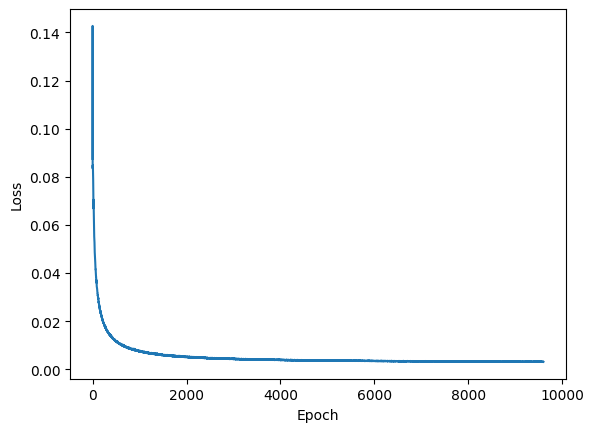

In [24]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

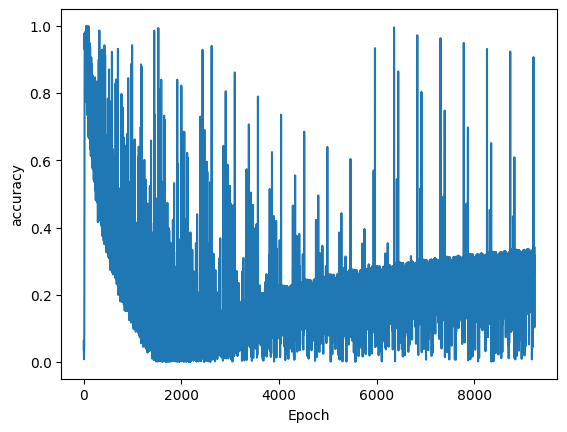

In [25]:
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

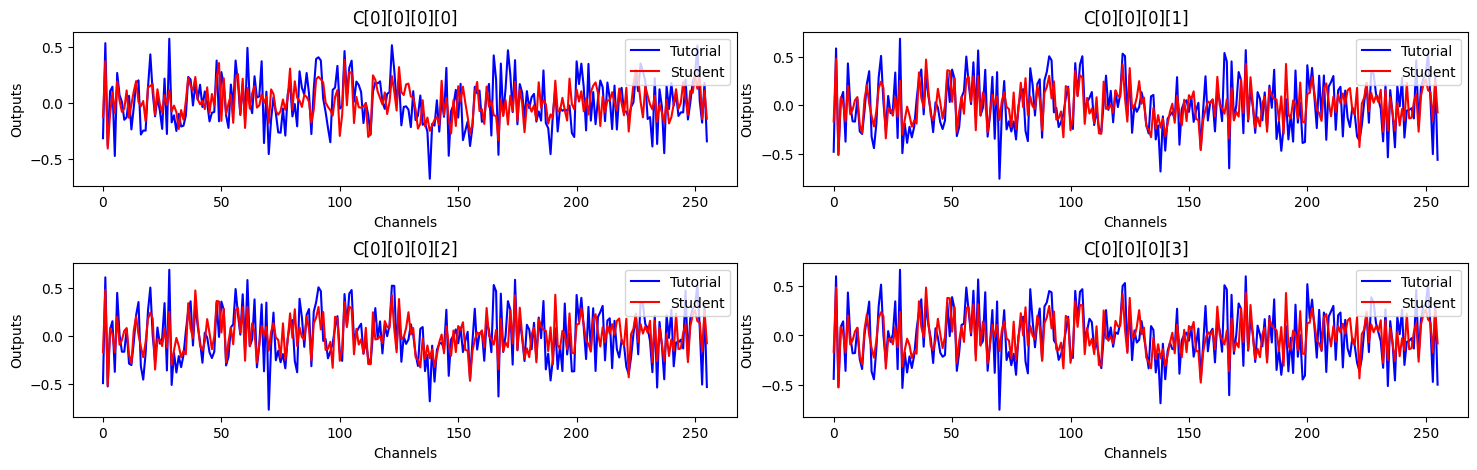

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

channels = [0,1,2,3]

for i, ax in enumerate(axs.flatten()):
    # Plot the tutorial and student outputs for a given channel
    ax.plot(C1[0][0][0][channels[i]], 'b', label='Tutorial')
    ax.plot(SC1[0][0][0][channels[i]], 'r', label='Student')
    ax.set_xlabel('Channels')
    ax.set_ylabel('Outputs')
    ax.set_title('C[0][0][0][{}]'.format(channels[i]))
    ax.legend(loc='upper right')

plt.show()

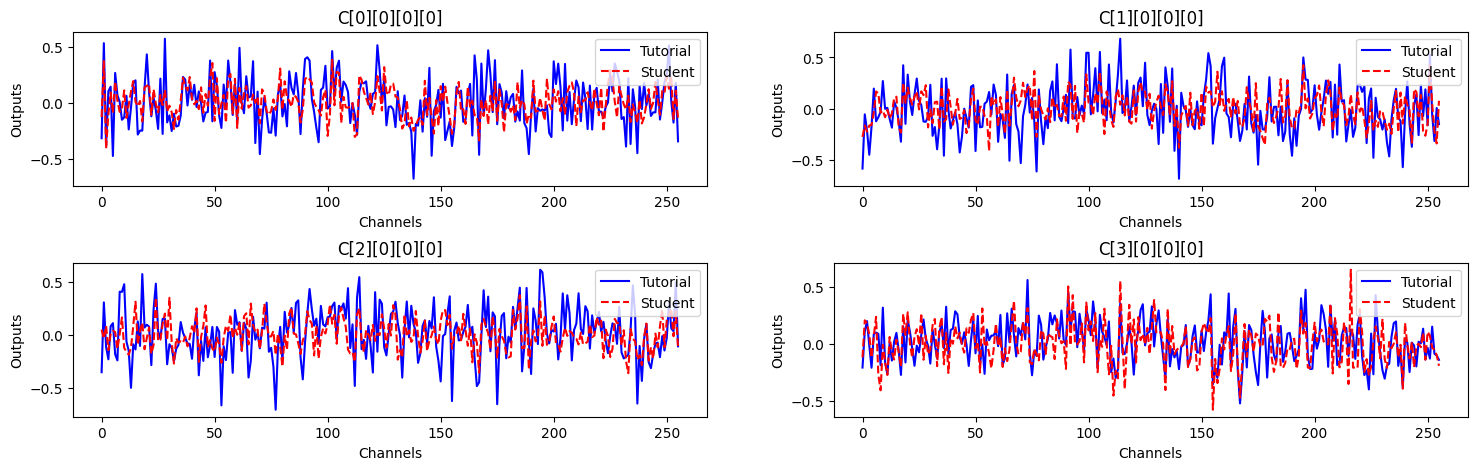

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

channels = [0, 1, 2, 3]

for i, ax in enumerate(axs.flatten()):
    # Plot the tutorial and student outputs for a given channel
    ax.plot(C1[channels[i]][0][0][0:99][0], 'b', label='Tutorial')
    ax.plot(SC1[channels[i]][0][0][0:99][0], 'r--', label='Student')
    ax.set_xlabel('Channels')
    ax.set_ylabel('Outputs')
    ax.set_title('C[{}][0][0][0]'.format(channels[i]))
    ax.legend(loc='upper right')

plt.show()

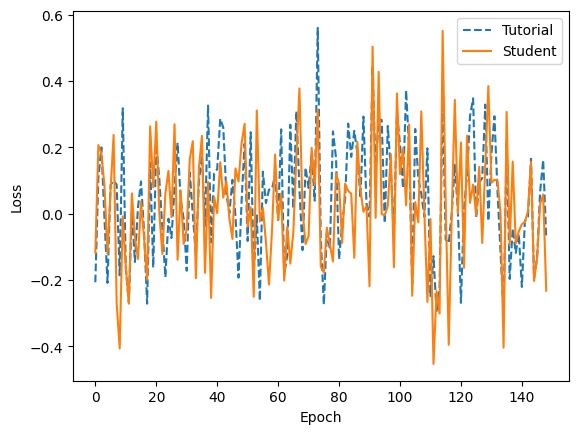

In [33]:
plt.plot(C1[3][0][0][0][0:149], label='Tutorial', linestyle='--')
plt.plot(SC1[3][0][0][0][0:149], label='Student', linestyle='solid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [34]:
channel_num = 0

feature_maps = tutorial_model.predict(val_data_gen[0][0])[channel_num]
student_maps = student_new.predict(val_data_gen[0][0])[channel_num]

In [35]:
square = 4

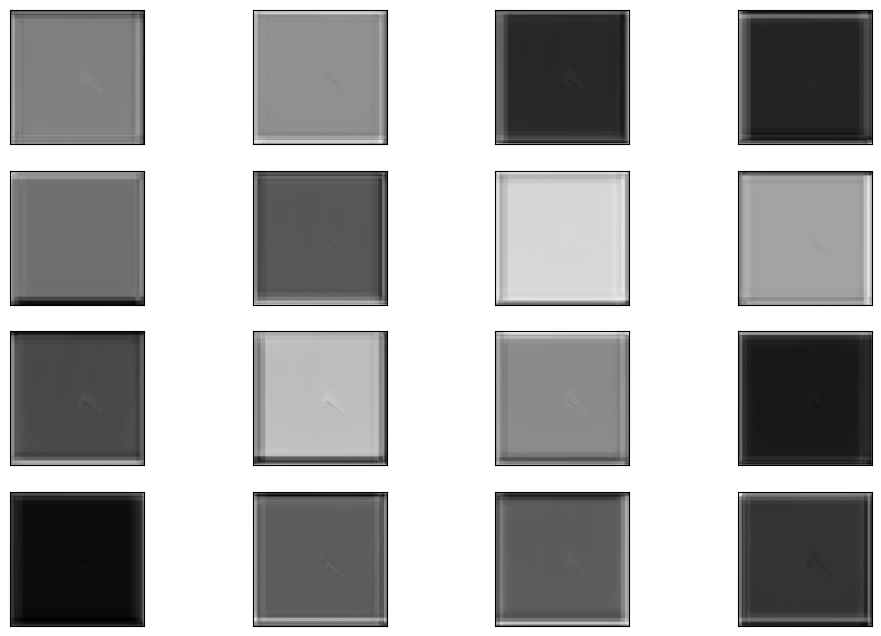

In [36]:
ix = 1
plt.figure(figsize=(12,8))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
			# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
	# show the figure
plt.show()

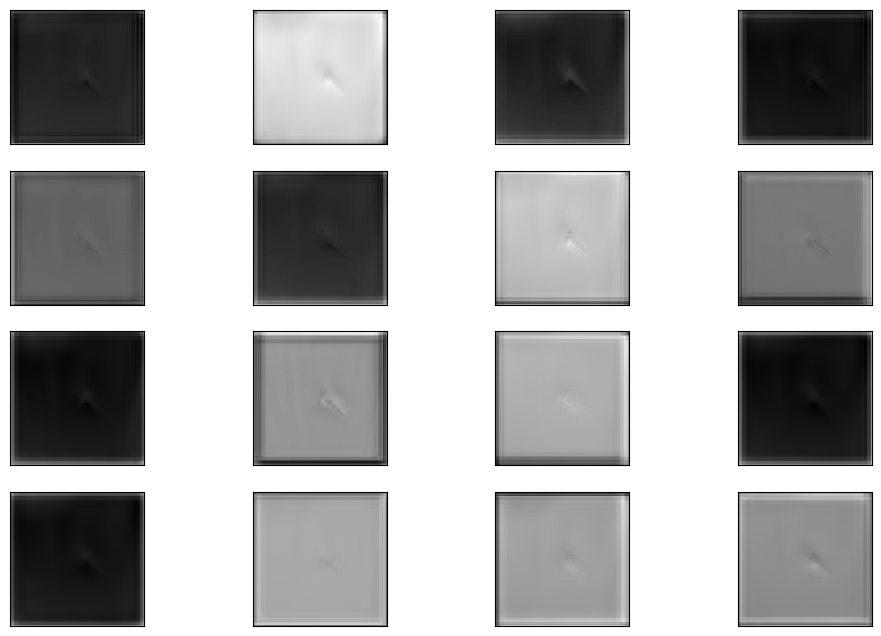

In [37]:
ix = 1
plt.figure(figsize=(12,8))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
			# plot filter channel in grayscale
		plt.imshow(student_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
	# show the figure
plt.show()

## Save Weighting

In [38]:
student_new.save("E:\KD\ResNet18\Teacher-34\P\student_P_rt.h5")

c:\Users\user\anaconda3\envs\tf_2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
student_new.save_weights("E:\KD\ResNet18\Teacher-34\P\student_P_rt_weights.h5")